<a href="https://colab.research.google.com/github/gmadaan15/MultilabelOnMissingLabels/blob/main/MultilabelOnMissingLabels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This work was part of an assessment process by an ML company(Aimonk) for the recruitment of an ML based position. The assignment is about doing deep learning Multilabel classification on a blackbox dataset with missing labels using transfer learning from a pretrained model(we choose resnet for that). The dataset's labels are just named as attr1, attr2, att3 and attr4 without much explaination of what they are representing in the dataset image given.

The bigger challenge here is to fill the missing labels and we choose KNN. the section uses the sklearn based KNN to fill the missing. Later, in the third section Multilabel Classification is done using the pretrained features.

More information can be taken from this document: [link](https://drive.google.com/file/d/1hR7ocdsaOYiGuh5__fjqy-wLkbj6fdm7/view?usp=sharing)

Dataset can be accessed from : [data](https://drive.google.com/drive/folders/1j0XuZYyFMAAP-iIiJkVNOxj0dDwVVT-t?usp=sharing)

In [1]:
!python3 -V

Python 3.7.13


#Filling the Unavailable Data.
The idea here is to find similar or say close by images to the missing data images and use them to predict the missing value. Basically KNN model, so we choose this because this is simple, intuitive and non linear by default. Instead of using the raw images as input to KNN predictor, we used embedding that we get from the pretrained model,

In [ ]:
!ls

drive  sample_data


Making sure that the images are there in the colab workspace. Note 3 images are missing. We solved this problem by taking the images that had the same values for output for all the output values.

In [ ]:
!unzip /content/drive/MyDrive/Multilabel.zip -d ./

Archive:  /content/drive/MyDrive/Multilabel.zip
replace ./__MACOSX/._Multilabel? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./__MACOSX/._Multilabel  
  inflating: ./__MACOSX/Multilabel/._images  
  inflating: ./Multilabel/labels.txt  
  inflating: ./__MACOSX/Multilabel/._labels.txt  
  inflating: ./Multilabel/images/image_811.jpg  
  inflating: ./__MACOSX/Multilabel/images/._image_811.jpg  
  inflating: ./Multilabel/images/image_805.jpg  
  inflating: ./__MACOSX/Multilabel/images/._image_805.jpg  
  inflating: ./Multilabel/images/image_193.jpg  
  inflating: ./__MACOSX/Multilabel/images/._image_193.jpg  
  inflating: ./Multilabel/images/image_187.jpg  
  inflating: ./__MACOSX/Multilabel/images/._image_187.jpg  
  inflating: ./Multilabel/images/image_839.jpg  
  inflating: ./__MACOSX/Multilabel/images/._image_839.jpg  
  inflating: ./Multilabel/images/image_178.jpg  
  inflating: ./__MACOSX/Multilabel/images/._image_178.jpg  
  inflating: ./Multilabel/images/image_636.jpg  
  

In [ ]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

Reading the csv so that we can fill the missing values

In [ ]:
df = pd.read_csv('/content/Multilabel/labels.txt', delim_whitespace=True, names=["id", "attr1", "attr2", "attr3", 'attr4'])
print(df)

                id  attr1  attr2  attr3  attr4
0      image_0.jpg    1.0    NaN    0.0    1.0
1      image_1.jpg    NaN    0.0    0.0    0.0
2      image_2.jpg    1.0    1.0    0.0    0.0
3      image_3.jpg    1.0    1.0    0.0    0.0
4      image_4.jpg    1.0    1.0    0.0    0.0
..             ...    ...    ...    ...    ...
970  image_970.jpg    1.0    1.0    1.0    1.0
971  image_971.jpg    1.0    1.0    0.0    0.0
972  image_972.jpg    1.0    NaN    1.0    0.0
973  image_973.jpg    0.0    1.0    0.0    0.0
974  image_974.jpg    NaN    1.0    1.0    1.0

[975 rows x 5 columns]


The pretrained Resnet model

In [ ]:
from torchvision import models as models
pretrained_model = models.resnet50(progress=True, pretrained=True)
for param in pretrained_model.parameters():
  param.requires_grad = False
pretrained_model.fc = nn.Linear(2048, 2048)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Code to convert an array of image names to an array of pretrained embeddings in the batches of 32

In [ ]:
import os
def get_X(df):
  X = []
  transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])
  X = np.array([])
  images = []
  to_be_removed = []
  for ind in tqdm(df.index, miniters=0.00001):
    #print(ind)
    image_name = df.loc[ind, "id"]
    path = f"/content/Multilabel/images/{image_name}"
    #print(path)
    if not os.path.isfile(path):
      #ignore if no such file is present.
      to_be_removed.append(ind)
      print(path)
      continue
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = transform(image)
    image = cv2.resize(image, (400,400))
    #image = torch.tensor(image, dtype=torch.float32)
    images.append(image)
    if len(images) == 32:
      X_tensor =  torch.tensor(images, device = device, dtype=torch.float32)
      X_tensor = X_tensor.permute(0,3,1,2)
      out = pretrained_model(X_tensor)
      if len(X) !=0:
        X = np.concatenate((X, out.cpu().detach().numpy()), axis=0)
      else:
        X = out.cpu().detach().numpy()
      images.clear()
  
  if len(images) !=0:
    X_tensor = torch.tensor(images, device = device, dtype=torch.float32)
    X_tensor = X_tensor.permute(0,3,1,2)
    out = pretrained_model(X_tensor)
    if len(X) !=0:
      X = np.concatenate((X, out.cpu().detach().numpy()), axis=0)
    else:
      X = out.cpu().detach().numpy()
    images.clear()
  #df.drop(to_be_removed, axis=0, inplace=True)
  #X = pretrained_model(X)
  return X

Function to fill the missing values, Note we are sklearn's KNN to fill the missing values.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

def fill_missing_entries(df, attr):
  df_attr_train = df[(df.loc[:, attr]==1.0) | (df.loc[:, attr]==0.0)]
  df_attr_pred = df[(df.loc[:, attr]!=1.0) & (df.loc[:, attr]!=0.0)]

  print(df_attr_train)
  print(df_attr_pred)

  pred_X = get_X(df_attr_pred)
  #nsamples, nx, ny = pred_X.shape
  #pred_X = pred_X.reshape((nsamples,nx*ny))

  train_X = get_X(df_attr_train)
  print(train_X.shape)
  #nsamples, nx, ny = train_X.shape
  #train_X = train_X.reshape((nsamples,nx*ny))

  train_y = df_attr_train[attr].values
  #train_y = train_y.reshape(train_y.shape[0], 1)
  
  parameters = {"n_neighbors": range(1, 40)}
  gridsearch = GridSearchCV(KNeighborsClassifier(weights= 'distance'), parameters)
  gridsearch.fit(train_X, train_y)
  print(gridsearch.best_params_)
  
  pred_y  = gridsearch.predict(pred_X)
  print(pred_y)
  df_attr_pred.loc[:, attr] = pred_y
  #for i in range(len(df_attr_pred[attr])):
    #df_attr_pred[attr][i] = pred_y[i]
  print(df_attr_pred)
  frames = [df_attr_train, df_attr_pred]
  df1 = pd.concat(frames)
  print(df1[(df1.loc[:, attr]!=1.0) & (df1.loc[:, attr]!=0.0)])
  return df1
  #print(df)

Main type of code to call the above functions to fill the missing values and save the output file.

In [ ]:
print("====================================================================")
df = fill_missing_entries(df, 'attr1')
print(df[(df.loc[:, 'attr1']!=1.0) & (df.loc[:, 'attr1']!=0.0)])
df.to_csv('attr1.csv')
print("=====================================================================")
#df = pd.read_csv('/content/Multilabel/labels.txt', delim_whitespace=True, names=["id", "attr1", "attr2", "attr3", 'attr4'])
df = fill_missing_entries(df, 'attr2')
print(df[(df.loc[:, 'attr2']!=1.0) & (df.loc[:, 'attr2']!=0.0)])
df.to_csv('attr2.csv')
print("=====================================================================")
#df = pd.read_csv('/content/Multilabel/labels.txt', delim_whitespace=True, names=["id", "attr1", "attr2", "attr3", 'attr4'])
df = fill_missing_entries(df, 'attr3')
print(df[(df.loc[:, 'attr3']!=1.0) & (df.loc[:, 'attr3']!=0.0)])
df.to_csv('attr3.csv')
print("=====================================================================")
#df = pd.read_csv('/content/Multilabel/labels.txt', delim_whitespace=True, names=["id", "attr1", "attr2", "attr3", 'attr4'])
df = fill_missing_entries(df, 'attr4')
print(df[(df.loc[:, 'attr4']!=1.0) & (df.loc[:, 'attr4']!=0.0)])
df.to_csv('attr4.csv')

                id  attr1  attr2  attr3  attr4
0      image_0.jpg    1.0    NaN    0.0    1.0
2      image_2.jpg    1.0    1.0    0.0    0.0
3      image_3.jpg    1.0    1.0    0.0    0.0
4      image_4.jpg    1.0    1.0    0.0    0.0
6      image_6.jpg    1.0    1.0    0.0    0.0
..             ...    ...    ...    ...    ...
969  image_969.jpg    1.0    1.0    NaN    0.0
970  image_970.jpg    1.0    1.0    1.0    1.0
971  image_971.jpg    1.0    1.0    0.0    0.0
972  image_972.jpg    1.0    NaN    1.0    0.0
973  image_973.jpg    0.0    1.0    0.0    0.0

[895 rows x 5 columns]
                id  attr1  attr2  attr3  attr4
1      image_1.jpg    NaN    0.0    0.0    0.0
5      image_5.jpg    NaN    0.0    1.0    NaN
18    image_18.jpg    NaN    1.0    1.0    NaN
41    image_41.jpg    NaN    1.0    0.0    0.0
45    image_45.jpg    NaN    1.0    0.0    0.0
..             ...    ...    ...    ...    ...
930  image_930.jpg    NaN    1.0    NaN    0.0
938  image_938.jpg    NaN    1.0    

100%|██████████| 895/895 [02:34<00:00,  5.80it/s]


(895, 2048)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


{'n_neighbors': 15}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
                id  attr1  attr2  attr3  attr4
1      image_1.jpg    1.0    0.0    0.0    0.0
5      image_5.jpg    1.0    0.0    1.0    NaN
18    image_18.jpg    1.0    1.0    1.0    NaN
41    image_41.jpg    1.0    1.0    0.0    0.0
45    image_45.jpg    1.0    1.0    0.0    0.0
..             ...    ...    ...    ...    ...
930  image_930.jpg    1.0    1.0    NaN    0.0
938  image_938.jpg    1.0    1.0    1.0    0.0
948  image_948.jpg    1.0    1.0    1.0    0.0
962  image_962.jpg    1.0    0.0    1.0    1.0
974  image_974.jpg    1.0    1.0    1.0    1.0

[80 rows x 5 columns]
Empty DataFrame
Columns: [id, attr1, attr2, attr3, attr4]
Index: []
Empty DataFrame
Columns: [id, attr1, attr2, attr3, attr4]
Index: []
            

100%|██████████| 884/884 [02:33<00:00,  5.77it/s]


(884, 2048)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


{'n_neighbors': 21}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
                id  attr1  attr2  attr3  attr4
0      image_0.jpg    1.0    1.0    0.0    1.0
9      image_9.jpg    1.0    1.0    1.0    0.0
14    image_14.jpg    1.0    1.0    0.0    0.0
26    image_26.jpg    1.0    1.0    1.0    0.0
37    image_37.jpg    0.0    1.0    1.0    0.0
..             ...    ...    ...    ...    ...
972  image_972.jpg    1.0    1.0    1.0    0.0
80    image_80.jpg    1.0    1.0    1.0    0.0
305  image_305.jpg    1.0    1.0    0.0    0.0
686  image_686.jpg    1.0    1.0    1.0    0.0
785  image_785.jpg    1.0    1.0    1.0    0.0

[91 rows x 5 columns]
Empty DataFrame
Columns: [id, attr1, attr2, attr3, attr4]
Index: []
Empty DataFrame
Columns: [id, attr1, attr2, att

100%|██████████| 882/882 [02:32<00:00,  5.77it/s]


(882, 2048)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


{'n_neighbors': 25}
[1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0.]
                id  attr1  attr2  attr3  attr4
32    image_32.jpg    1.0    1.0    1.0    0.0
35    image_35.jpg    1.0    1.0    1.0    0.0
39    image_39.jpg    1.0    1.0    0.0    NaN
49    image_49.jpg    0.0    1.0    0.0    0.0
59    image_59.jpg    1.0    1.0    0.0    0.0
..             ...    ...    ...    ...    ...
485  image_485.jpg    1.0    1.0    0.0    0.0
507  image_507.jpg    1.0    1.0    1.0    0.0
600  image_600.jpg    1.0    1.0    0.0    0.0
654  image_654.jpg    1.0    1.0    1.0    0.0
861  image_861.jpg    1.0    1.0    0.0    0.0

[93 rows x 5 columns]
Empty DataFrame
Columns: [id, attr1, attr2, attr3, attr4]
Index: []
Empty DataFrame
Columns: [id, attr1, attr

100%|██████████| 881/881 [02:33<00:00,  5.75it/s]


(881, 2048)
{'n_neighbors': 9}
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                id  attr1  attr2  attr3  attr4
44    image_44.jpg    1.0    1.0    1.0    0.0
47    image_47.jpg    1.0    1.0    0.0    0.0
89    image_89.jpg    1.0    1.0    0.0    0.0
93    image_93.jpg    1.0    1.0    1.0    0.0
131  image_131.jpg    0.0    1.0    1.0    0.0
..             ...    ...    ...    ...    ...
427  image_427.jpg    1.0    1.0    1.0    0.0
533  image_533.jpg    1.0    1.0    1.0    0.0
572  image_572.jpg    1.0    1.0    0.0    0.0
875  image_875.jpg    1.0    1.0    0.0    0.0
942  image_942.jpg    1.0    1.0    0.0    0.0

[94 rows x 5 columns]
Empty DataFrame
Columns: [id, attr1, attr2, attr3, attr4]
Index: []
Empty DataFrame
Columns: [i

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# MultiLabel Classification
Second part: We use deep learning to do this. The idea is simple, instead of applying cross entropy loss on the comple set of output values(that we mostly do in Multiclassification), we separately apply binary cross entropy loss on the output values. This enables us to predict with some probability value about presence and absence of single-single attribute separately.

In [ ]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from torch.utils.data import DataLoader

Data set class. slightly modified to instantiate train, validate and test data

In [ ]:
dataset_types = {'TRAIN':0, 'TEST':1, 'VALIDATION':2}
train_ratio = 0.88
validation_ratio = 0.1
class ImageDataset(Dataset):
    def __init__(self, csv, dataset_type):
        self.csv = csv
        self.dataset_type = dataset_type
        self.all_image_names = self.csv[:]['id']
        self.all_labels = np.array(self.csv.drop(['id', 'oldIdx'], axis=1))
        train_len = int(train_ratio * len(self.csv))
        validation_len = int(validation_ratio*train_len)
        test_len = len(self.csv) - train_len
        # set the training data images and labels
        if self.dataset_type == dataset_types['TRAIN']:
            self.image_names = list(self.all_image_names[:train_len])
            self.labels = list(self.all_labels[:train_len])
            self.image_names = list(self.all_image_names[:train_len-validation_len])
            self.labels = list(self.all_labels[:train_len-validation_len])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])
        # set the validation data images and labels
        elif self.dataset_type == dataset_types['VALIDATION']:
            self.image_names = list(self.all_image_names[:train_len])
            self.labels = list(self.all_labels[:train_len])
            self.image_names = list(self.all_image_names[-validation_len:])
            self.labels = list(self.all_labels[-validation_len:])
             # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])
        # set the test data images and labels
        elif self.dataset_type == dataset_types['TEST']:
            self.image_names = list(self.all_image_names[-test_len:])
            self.labels = list(self.all_labels[test_len:])
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])


  
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        image = cv2.imread(f"/content/Multilabel/images/{image_name}")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

     Unnamed: 0             id  attr1  attr2  attr3  attr4
0             2    image_2.jpg    1.0    1.0    0.0    0.0
1             3    image_3.jpg    1.0    1.0    0.0    0.0
2             4    image_4.jpg    1.0    1.0    0.0    0.0
3             6    image_6.jpg    1.0    1.0    0.0    0.0
4             7    image_7.jpg    1.0    1.0    1.0    0.0
..          ...            ...    ...    ...    ...    ...
970         427  image_427.jpg    1.0    1.0    1.0    0.0
971         533  image_533.jpg    1.0    1.0    1.0    0.0
972         572  image_572.jpg    1.0    1.0    0.0    0.0
973         875  image_875.jpg    1.0    1.0    0.0    0.0
974         942  image_942.jpg    1.0    1.0    0.0    0.0

[975 rows x 6 columns]


Again, pretrained model for learning with its final layer changed to output 4 values instead of 1000.

In [ ]:
from torchvision import models as models
import torch.nn as nn
num_classes = 4
def transferred_model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 4 classes in total
    model.fc = nn.Linear(2048, num_classes)
    return model

Function to compute accuracy while we train and validate simmultaneously

In [ ]:
def compute_accuracy(predicted, target):
  accuracy = 0.0
  #print(predicted)
  #print(torch.round(predicted))
  #print(torch.eq(torch.round(predicted), target).double())
  with torch.no_grad():
    accuracy = torch.mean(torch.eq(torch.round(predicted), target).double())
  return accuracy
  

Train Function

In [ ]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    
    model.train()
    counter = 0
    train_running_loss = 0.0
    accuracy = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)+1):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        #print(data.shape)
        #print(len(target))
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        #print(outputs)
        #print(target)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        accuracy += compute_accuracy(outputs, target)
        
    train_loss = train_running_loss / counter
    accuracy = accuracy/counter
    return train_loss, accuracy

Validate function. Note the no_grad function there. Can also be used during the test phase.

In [ ]:
# validation function
def validate(model, dataloader, criterion, val_data, device):
    
    model.eval()
    counter = 0
    val_running_loss = 0.0
    accuracy = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)+1):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            #print(outputs)
            #print(target)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            accuracy += compute_accuracy(outputs, target)
        
        val_loss = val_running_loss / counter
        accuracy = accuracy/counter
        return val_loss, accuracy

Driver code to actually intiate the training process in multiple epochs.

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


     oldIdx             id  attr1  attr2  attr3  attr4
0         2    image_2.jpg    1.0    1.0    0.0    0.0
1         3    image_3.jpg    1.0    1.0    0.0    0.0
2         4    image_4.jpg    1.0    1.0    0.0    0.0
3         6    image_6.jpg    1.0    1.0    0.0    0.0
4         7    image_7.jpg    1.0    1.0    1.0    0.0
..      ...            ...    ...    ...    ...    ...
970     427  image_427.jpg    1.0    1.0    1.0    0.0
971     533  image_533.jpg    1.0    1.0    1.0    0.0
972     572  image_572.jpg    1.0    1.0    0.0    0.0
973     875  image_875.jpg    1.0    1.0    0.0    0.0
974     942  image_942.jpg    1.0    1.0    0.0    0.0

[975 rows x 6 columns]
773
85
117
Epoch 1 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train Loss: 0.6760, Train Accuracy : 0.5529
Val Loss: 0.6442, Val Accuracy : 0.7092
Epoch 2 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Train Loss: 0.6211, Train Accuracy : 0.6805
Val Loss: 0.6050, Val Accuracy : 0.7670
Epoch 3 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Train Loss: 0.5804, Train Accuracy : 0.7814
Val Loss: 0.5649, Val Accuracy : 0.7763
Epoch 4 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train Loss: 0.5472, Train Accuracy : 0.7889
Val Loss: 0.5412, Val Accuracy : 0.7852
Epoch 5 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.09it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train Loss: 0.5210, Train Accuracy : 0.7910
Val Loss: 0.5194, Val Accuracy : 0.7933
Epoch 6 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.09it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train Loss: 0.5029, Train Accuracy : 0.7906
Val Loss: 0.5024, Val Accuracy : 0.7906
Epoch 7 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train Loss: 0.4893, Train Accuracy : 0.7898
Val Loss: 0.4913, Val Accuracy : 0.7919
Epoch 8 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Train Loss: 0.4842, Train Accuracy : 0.7838
Val Loss: 0.4787, Val Accuracy : 0.7946
Epoch 9 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train Loss: 0.4680, Train Accuracy : 0.7951
Val Loss: 0.4735, Val Accuracy : 0.7800
Epoch 10 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.09it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train Loss: 0.4631, Train Accuracy : 0.7947
Val Loss: 0.4691, Val Accuracy : 0.7837
Epoch 11 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Train Loss: 0.4627, Train Accuracy : 0.7867
Val Loss: 0.4664, Val Accuracy : 0.7853
Epoch 12 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Train Loss: 0.4610, Train Accuracy : 0.7867
Val Loss: 0.4552, Val Accuracy : 0.7867
Epoch 13 of 20
Training


100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train Loss: 0.4585, Train Accuracy : 0.7831
Val Loss: 0.4606, Val Accuracy : 0.7878
Epoch 14 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train Loss: 0.4544, Train Accuracy : 0.7890
Val Loss: 0.4571, Val Accuracy : 0.7785
Epoch 15 of 20
Training


100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Train Loss: 0.4497, Train Accuracy : 0.7919
Val Loss: 0.4495, Val Accuracy : 0.7907
Epoch 16 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.09it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train Loss: 0.4503, Train Accuracy : 0.7873
Val Loss: 0.4475, Val Accuracy : 0.7892
Epoch 17 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.09it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Train Loss: 0.4536, Train Accuracy : 0.7884
Val Loss: 0.4373, Val Accuracy : 0.7959
Epoch 18 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.09it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Train Loss: 0.4469, Train Accuracy : 0.7909
Val Loss: 0.4493, Val Accuracy : 0.7878
Epoch 19 of 20
Training


100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Train Loss: 0.4487, Train Accuracy : 0.7929
Val Loss: 0.4374, Val Accuracy : 0.7986
Epoch 20 of 20
Training


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Validating


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Train Loss: 0.4541, Train Accuracy : 0.7869
Val Loss: 0.4388, Val Accuracy : 0.7972
#####################################################################
#####################################################################
Testing


 75%|███████▌  | 3/4 [00:02<00:00,  1.14it/s]


Test Loss: 0.4771, Test Accuracy : 0.7604


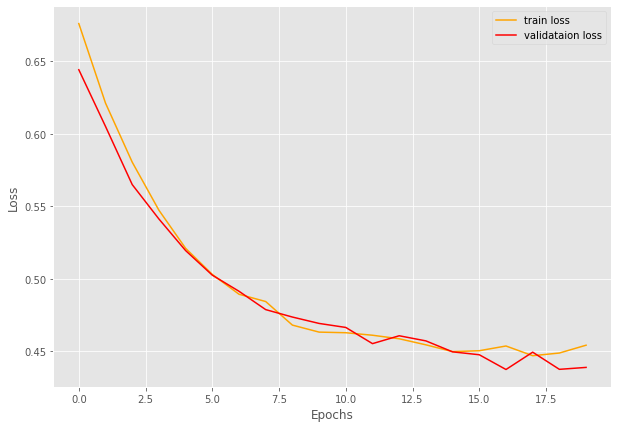

In [ ]:
matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#intialize the model
model = transferred_model(pretrained=True, requires_grad=False).to(device)
# learning parameters
lr = 0.00001
epochs = 20
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()


# read the training csv file
train_csv = pd.read_csv('/content/drive/MyDrive/attr4.csv')
train_csv.rename({"Unnamed: 0":"oldIdx"}, axis="columns", inplace=True)
print(train_csv)
# train dataset
train_data = ImageDataset(
    train_csv, dataset_type= dataset_types['TRAIN']
)
# validation dataset
valid_data = ImageDataset(
    train_csv, dataset_types['VALIDATION']
)
test_data = ImageDataset(train_csv, dataset_types['TEST'])
print(len(train_data))
print(len(valid_data))
print(len(test_data))
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=False
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=False
)
# test data loader
test_loader = DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
    drop_last=True
)

# start the training and validation
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print("============================================================================================")
    print(f"Epoch {epoch+1} of {epochs}")
    print('Training')
    train_epoch_loss, train_accuracy = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    print('Validating')
    valid_epoch_loss, valid_accuracy = validate(
        model, valid_loader, criterion, valid_data, device
    )
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy : {train_accuracy:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}, Val Accuracy : {valid_accuracy:.4f}')

    # save the trained model to disk
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, './model_{}_{}.pth'.format(epoch+1, valid_accuracy))
print("#####################################################################")
print("#####################################################################")
print('Testing')
test_epoch_loss, test_accuracy = validate(
    model, test_loader, criterion, test_data, device
    )

print(f'Test Loss: {test_epoch_loss:.4f}, Test Accuracy : {test_accuracy:.4f}')
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./loss.png')
plt.show()